# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions.cosmic_val import *
from functions.graph_tools import *
from functions.data_handling import data_augmentation
from models.muse import *
from functions import cosmic_val
from functions import data_handling as dh
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

# set seed
# np.random.seed(15)
# torch.manual_seed(15)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
L_ONE = 128
TOLERANCE = 1e-10
CONSTRAINT = 'identity'

In [6]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Dictionary of lists: {k: [iterations]}
results_dict = defaultdict(list)

losses_train = []
signatures = []
iterations = 2
k_range = 6

augmented_data = data_augmentation(X=data, augmentation=30)

for k in tqdm(range(4, k_range)):
    for i in range(iterations):
        
        muse_model = HybridAutoencoder(input_dim=data.shape[0],  # 96
                                        l_1=L_ONE,
                                        latent_dim=k,
                                        weights = 'xavier')

        # Training MUSE
        muse_error, muse_signatures, muse_exposures, muse_train_loss, muse_val_loss = train_model_for_extraction(
            model=muse_model,
            X_aug_multi_scaled=augmented_data.T,
            X_scaled=data.T,
            signatures=k,
            epochs=2000,
            batch_size=64,
            save_to='muse_test',
            iteration=i,
            patience=30,
            beta = 0.001
        )

        # Normalize signatures
        diagonals_muse = muse_signatures.sum(axis=0)
        muse_exposures = muse_exposures.T @ np.diag(diagonals_muse)
        muse_signatures = muse_signatures @ np.diag(1 / diagonals_muse)

        # Store results
        losses_train.append(muse_train_loss)
        signatures.append(muse_signatures)

        # Store data in structured format
        results_dict[k].append({
            "iteration": i,
            "muse_error": muse_error, # This is the reconstruction error
            "muse_signatures": muse_signatures  # Keep as NumPy array for easier processing
        })

    # Convert dictionary into a DataFrame for better analysis
    df_results = pd.DataFrame([
    {"k": k, "iteration": entry["iteration"], "muse_error": entry["muse_error"], "muse_signatures": entry["muse_signatures"]}
    for k, entries in results_dict.items()
    for entry in entries
    ])


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping at epoch 186


/home/nicovis/Projects/DeepLearningProject/models/muse.py:370: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
/home/nicovis

Early stopping at epoch 159
Early stopping at epoch 118


/home/nicovis/Projects/DeepLearningProject/models/muse.py:370: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))
/home/nicovis

Early stopping at epoch 180


In [ ]:
best_result = compute_consensus_signatures(df_results, avg_threshold=0.8, min_threshold=0.2)

print(best_result)

{'k': 4, 'iteration': 0, 'muse_error': 338763.9571830852, 'consensus_signatures': array([[0.00000000e+00, 2.30997447e-02, 0.00000000e+00, 0.00000000e+00],
       [2.74347956e-03, 1.81875005e-02, 3.21745384e-03, 4.94527211e-03],
       [1.02379192e-04, 2.94911722e-03, 2.14270403e-04, 1.31720895e-04],
       [2.65901592e-02, 1.73996203e-02, 1.84404291e-02, 9.43457615e-03],
       [3.49660945e-06, 1.26738837e-02, 2.79117467e-05, 5.06874994e-06],
       [0.00000000e+00, 6.55662920e-03, 3.60355552e-05, 0.00000000e+00],
       [0.00000000e+00, 3.87098501e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.24857360e-02, 1.07320807e-06, 0.00000000e+00],
       [0.00000000e+00, 1.85738914e-02, 0.00000000e+00, 0.00000000e+00],
       [6.54993171e-04, 9.17640235e-03, 3.73990217e-04, 1.33153535e-02],
       [0.00000000e+00, 2.48371400e-02, 8.48749373e-03, 0.00000000e+00],
       [1.12637412e-02, 1.65962018e-02, 1.18625611e-02, 4.21323208e-03],
       [0.00000000e+00, 9.37547162e-03, 1.

In [53]:
# Extract the muse_signatures for k = 5 and iteration = 1
muse_signatures_k5_iter1 = df_results[(df_results['k'] == 5) & (df_results['iteration'] == 1)]['muse_signatures'].values[0]
print(muse_signatures_k5_iter1)

consensus_signatures = muse_signatures_k5_iter1

[[1.91493782e-05 9.88953863e-04 2.49244403e-02 9.29838105e-04
  3.16515635e-03]
 [3.17208105e-06 7.29515264e-03 1.90672725e-02 3.05901244e-06
  2.29542190e-03]
 [6.84683546e-05 3.24525317e-04 3.28035746e-03 2.59627297e-04
  2.91449047e-04]
 [2.57476722e-03 3.38888392e-02 1.87084489e-02 1.29420562e-02
  3.32869636e-03]
 [2.03697756e-03 1.42919846e-04 1.36222821e-02 1.66809856e-04
  2.21650279e-03]
 [8.17860884e-04 0.00000000e+00 7.18713785e-03 7.52617139e-04
  3.96196730e-04]
 [9.84068151e-07 1.11646102e-06 4.27670730e-03 1.12645455e-06
  1.62469136e-04]
 [9.40131244e-08 0.00000000e+00 1.34758903e-02 0.00000000e+00
  1.67480449e-03]
 [0.00000000e+00 0.00000000e+00 1.61587708e-02 0.00000000e+00
  4.44434360e-02]
 [1.59219410e-02 8.03604722e-04 8.80619884e-03 3.68558872e-03
  1.30583066e-02]
 [7.10753538e-03 0.00000000e+00 2.08090059e-02 0.00000000e+00
  6.39210939e-02]
 [2.04384457e-02 3.63679440e-03 1.67386662e-02 6.11379137e-03
  1.44635849e-02]
 [0.00000000e+00 0.00000000e+00 9.776087

####  Optimize hyperparams & then run bunch of times. Adam lr & beta

In [9]:
print(np.mean(muse_val_loss))

480662.98333333334


In [22]:
all_signatures = np.hstack(signatures)

In [23]:
print(all_signatures.shape)

(96,)


In [24]:
pam = KMedoids(n_clusters = k, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

ValueError: Expected 2D array, got 1D array instead:
array=[0.02492444 0.01906727 0.00328036 0.01870845 0.01362228 0.00718714
 0.00427671 0.01347589 0.01615877 0.0088062  0.02080901 0.01673867
 0.00977609 0.00736001 0.01026995 0.01133347 0.01737225 0.00803243
 0.01095333 0.02145658 0.00503245 0.00203957 0.00657424 0.00546067
 0.01676462 0.01420774 0.00227161 0.0111619  0.00859991 0.00803997
 0.0034778  0.01248654 0.01363399 0.01190255 0.01191106 0.01915226
 0.00801269 0.01002227 0.01031522 0.01547899 0.00680288 0.00951561
 0.0060273  0.01046433 0.00320655 0.00344376 0.0064534  0.00796544
 0.01354741 0.01048985 0.00203471 0.01039101 0.00578962 0.00541296
 0.00175014 0.00874741 0.00926982 0.00722581 0.01056696 0.00986408
 0.00541302 0.00463797 0.006199   0.00948822 0.00605206 0.00522161
 0.00488434 0.00941338 0.00284545 0.00198496 0.00613673 0.00440779
 0.01961346 0.0168498  0.00235152 0.01281122 0.02684206 0.01399109
 0.00283736 0.04241417 0.0333108  0.01876334 0.01101953 0.02729861
 0.01150123 0.00804458 0.00572061 0.01461129 0.00863795 0.00822349
 0.00438816 0.00866217 0.00597959 0.00419719 0.00677407 0.00934782].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [54]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [55]:
print(matched_signatures)
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0  SBS10c      0.814495
1            1   SBS56      0.735695
2            2  SBS40a      0.864047
3            3  SBS10a      0.771226
4            4   SBS44      0.766166

Mean similarity of the matched signatures:  0.7903257738279054


In [46]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, j, "AENMF signature clusters")

ValueError: Expected 2D array, got 1D array instead:
array=[0.02492444 0.01906727 0.00328036 0.01870845 0.01362228 0.00718714
 0.00427671 0.01347589 0.01615877 0.0088062  0.02080901 0.01673867
 0.00977609 0.00736001 0.01026995 0.01133347 0.01737225 0.00803243
 0.01095333 0.02145658 0.00503245 0.00203957 0.00657424 0.00546067
 0.01676462 0.01420774 0.00227161 0.0111619  0.00859991 0.00803997
 0.0034778  0.01248654 0.01363399 0.01190255 0.01191106 0.01915226
 0.00801269 0.01002227 0.01031522 0.01547899 0.00680288 0.00951561
 0.0060273  0.01046433 0.00320655 0.00344376 0.0064534  0.00796544
 0.01354741 0.01048985 0.00203471 0.01039101 0.00578962 0.00541296
 0.00175014 0.00874741 0.00926982 0.00722581 0.01056696 0.00986408
 0.00541302 0.00463797 0.006199   0.00948822 0.00605206 0.00522161
 0.00488434 0.00941338 0.00284545 0.00198496 0.00613673 0.00440779
 0.01961346 0.0168498  0.00235152 0.01281122 0.02684206 0.01399109
 0.00283736 0.04241417 0.0333108  0.01876334 0.01101953 0.02729861
 0.01150123 0.00804458 0.00572061 0.01461129 0.00863795 0.00822349
 0.00438816 0.00866217 0.00597959 0.00419719 0.00677407 0.00934782].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [47]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

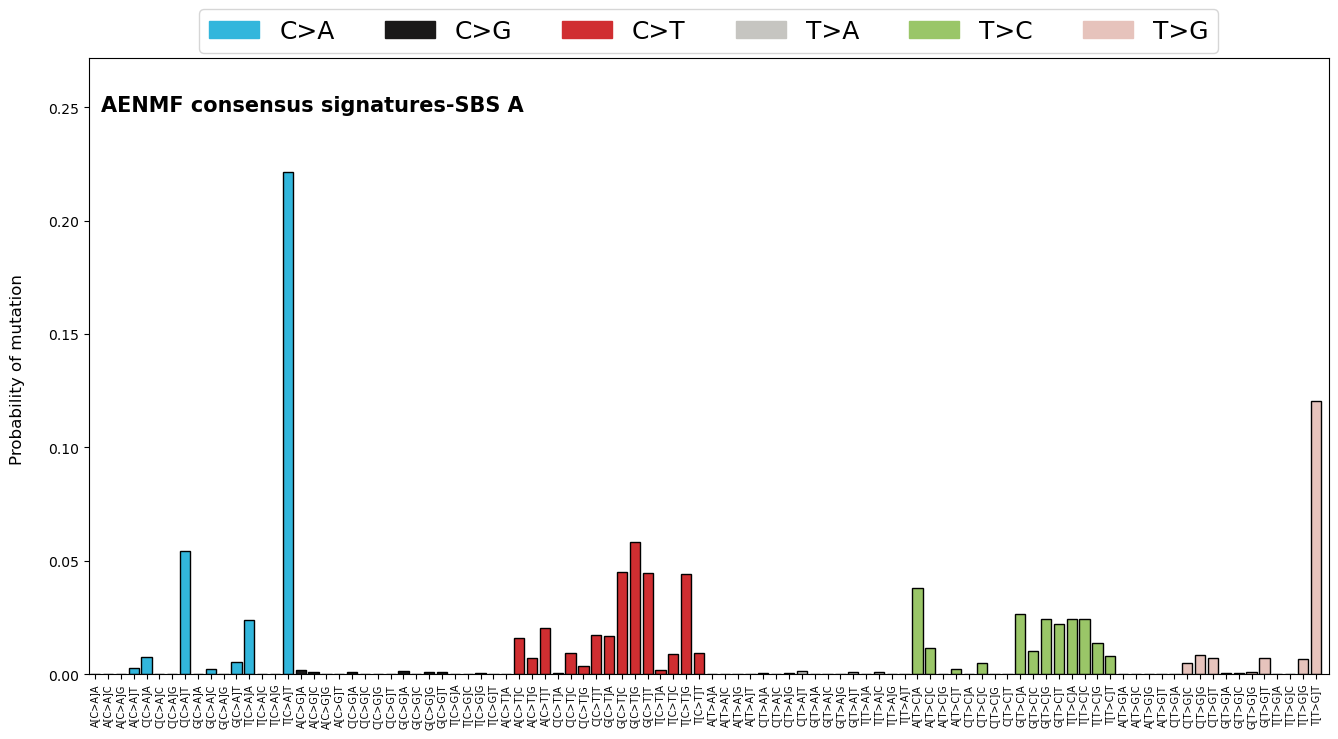

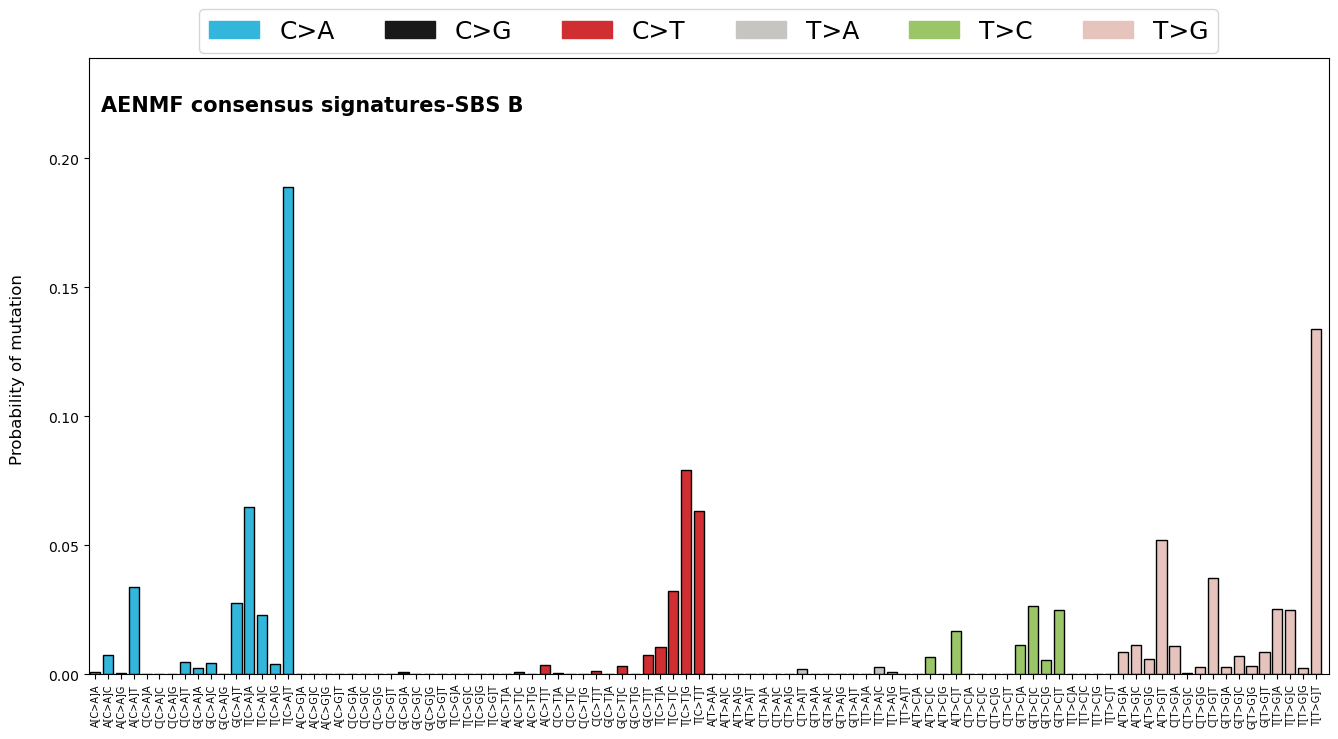

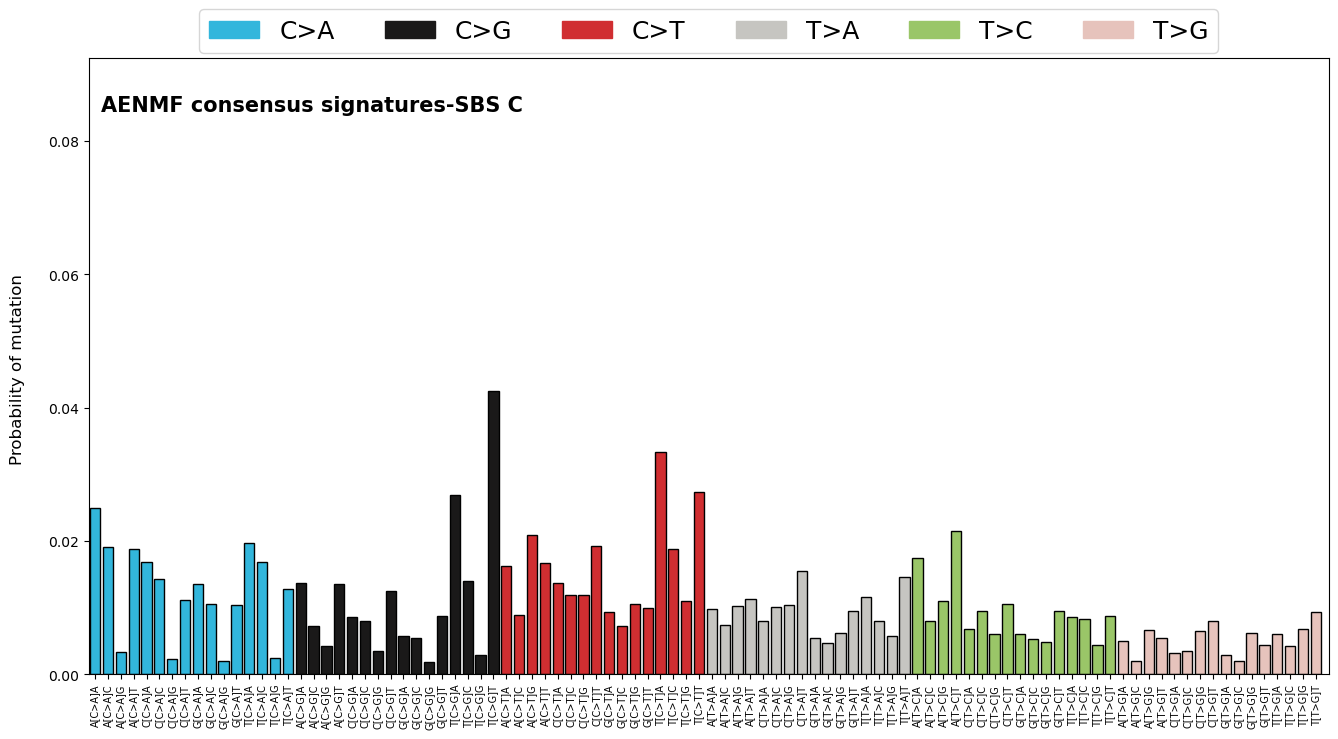

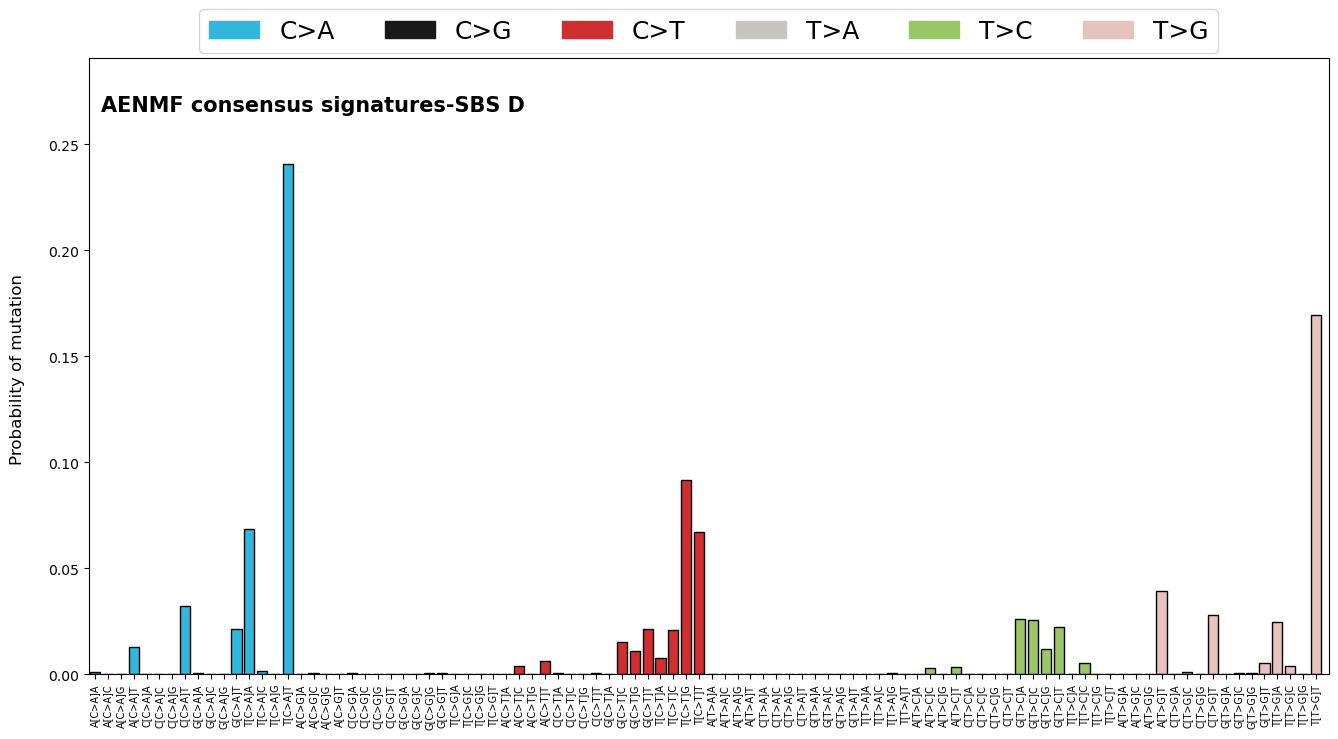

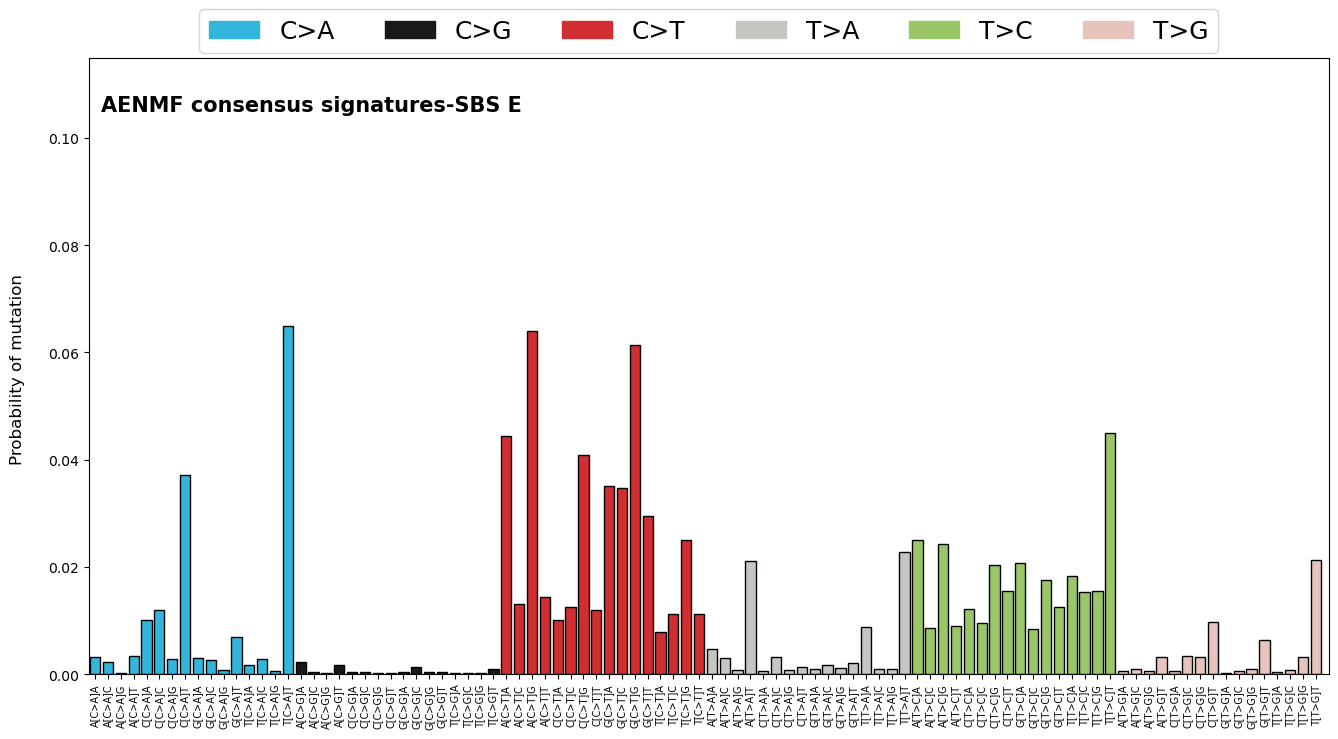

In [48]:
plot_signature(df_consensus, "AENMF consensus signatures")